# Aufgabe 12 - Discretization CartPol
29.01.2022, Thomas Iten

**Content**
1. Import the Necessary Packages
2. Specify the Environment, and Explore the State and Action Spaces
3. Discretize the State Space with a Uniform Grid
4. Visualization
5. Q-Learning
6. Modify the Grid
7. Watch a Smart Agent
8. Modify the Grid to Geomspace Grid

**References**
- https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
- https://realpython.com/np-linspace-numpy/#creating-ranges-of-numbers-with-uneven-spacing
- https://github.com/YuriyGuts/cartpole-q-learning/blob/master/cartpole.py

## 1. Import the Necessary Packages

In [1]:
import sys
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
plt.ion()



## 2. Specify the Environment, and Explore the State and Action Spaces

### Environment

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's use an environment that has a continuous state space, but a discrete action space.

In [2]:
# Create an environment and set random seed
env = gym.make('CartPole-v0')
env.seed(505);

### Run a random agent

Score:  38


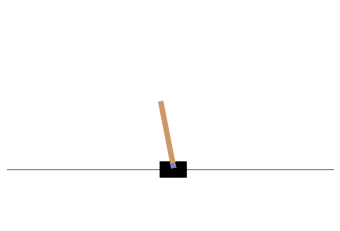

In [3]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        print('Score: ', t+1)
        break
        
env.close()

### Observations

| Num  |  Observation            | Min                     | Max
| ---- | ----------------------- | ----------------------- | -----------------------
|  0   |  Cart Position          |   -2.4                  |  2.4
|  1   |  Cart Velocity          |   -Inf                  |  Inf
|  2   |  Pole Angle             |   -0.209 rad (-12 deg)  |  0.209 rad (12 deg)
|  3   |  Pole Angular Velocity  |   -Inf                  |  Inf


In [4]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

State space: Box([-4.800e+00 -3.403e+38 -4.189e-01 -3.403e+38], [4.800e+00 3.403e+38 4.189e-01 3.403e+38], (4,), float32)
- low: [-4.800e+00 -3.403e+38 -4.189e-01 -3.403e+38]
- high: [4.800e+00 3.403e+38 4.189e-01 3.403e+38]


In [5]:
# Generate some samples from the state space 
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))


State space samples:
[[ 5.370e-01  1.525e+38  2.636e-02  1.250e+37]
 [ 3.930e+00 -2.579e+38 -1.411e-01 -1.322e+38]
 [-2.765e+00 -2.811e+38 -3.816e-02  1.439e+38]
 [ 1.571e+00  1.068e+38 -3.957e-01  2.824e+38]
 [-3.040e+00 -2.335e+38 -2.919e-01  2.193e+38]
 [-3.480e+00  2.994e+37  2.838e-01  1.268e+38]
 [-1.366e+00 -1.482e+38  1.448e-01 -1.566e+38]
 [-1.880e+00  1.147e+38 -1.828e-01 -2.823e+38]
 [-9.112e-01 -3.273e+38 -1.842e-01  1.774e+38]
 [-9.090e-01 -7.606e+37 -3.076e-01  2.422e+38]]


### Actions

Actions:
Type: Discrete(2)

| Num  | Action
| ---- | -----------------------
| - 0  | Push cart to the left
| - 1  | Push cart to the right

In [6]:
# Explore the action space
print("Action space:", env.action_space)

# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

Action space: Discrete(2)
Action space samples:
[0 0 0 1 0 1 0 1 1 0]


## 3. Discretize the State Space with a Uniform Grid

Note that the ends of `low` and `high` are **not** included in these split points.
It is assumed that any value below the lowest split point maps to index `0` and any value above
the highest split point maps to index `n-1`, where `n` is the number of bins along that dimension.

### Grid class

In [7]:
class Grid:

    @staticmethod
    def create_uniform_grid(low, high, bins):
        """Define a uniformly-spaced grid that can be used to discretize a space.

        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of the continuous space.
        high : array_like
            Upper bounds for each dimension of the continuous space.
        bins : tuple
            Number of bins along each corresponding dimension.

        Returns
        -------
        grid : list of array_like
            A list of arrays containing split points for each dimension.

        Sample
        ------
                ------------------------------------------
        Bins:  ¦ 1 ¦ 2 ¦ 3 ¦ 4 ¦ 5 ¦ 6 ¦ 7 ¦ 8 ¦ 9 ¦ 10 ¦
               ------------------------------------------
        Grid:  [   1,  2,  3,  4,  5,  6,  7,  8,  9   ] (Split Points= bins-1)
        """
        grids = []
        for low, high, b in zip(low, high, bins):
            # print(low, high, b+1)
            grid = np.linspace(low,high,b+1)[1:-1]
            grids.append(grid)
        return grids


    @staticmethod
    def create_geomspace(start, end, bins, zero_start=0.1):
        """Create geomspace according the following rules:

        1) If start is zero, the zero_start number will be used as start value for the split.
        2) If start is negative
           a) the split will be half/half for the positive and negative ranges.
           b) the zero_start number will be used as start value for each half.
           c) a zero value will be added between the positive an negative range
           d) only even bin number deliver the demanded number of bins
        """

        if start > 0:
            return np.geomspace(start, end, bins+1)[1:-1]

        if start == 0:
            return np.geomspace(zero_start, end, bins+1)[1:-1]

        result = []
        b_half = int(bins/2)
        n_range = (np.geomspace(zero_start, -start, b_half)*-1)[:-1]
        p_range = np.geomspace(zero_start, end, b_half)[:-1]

        for n  in reversed(n_range):
            result.append(n)
        result.append(0)
        for p in p_range:
            result.append(p)
        return result

    @staticmethod
    def create_geomspace_grid(low, high, bins):
        grids = []
        for low, high, b in zip(low, high, bins):
            # print(low, high, b+1)
            grid = Grid.create_geomspace(low,high,b)
            grids.append(grid)
        return grids


    @staticmethod
    def create_mixed_grid(low, high, bins, func):
        """Create mixed grid with "geom" oder "uni" function.

        Sample
        ------
        low  = [ 1,  1, -10, -10]
        high = [10, 10,  10,  10]
        bins = (10, 10,  10,  10)
        func = ("uni", "geom", "uni", "geom")

        grids = create_mixed_grid(low, high, bins, func)
        """
        grids = []
        for low, high, b, f in zip(low, high, bins, func):
            if f == "geom":
                grid = Grid.create_geomspace(low,high,b)
            else:
                grid = np.linspace(low,high,b+1)[1:-1]
            grids.append(grid)
        return grids


### Create Uniform Grid with limited observation space

In [8]:
low  = env.observation_space.low #
high = env.observation_space.high # [1.0, 5.0]
bins = (10,10,10,10)

print("- low:", low)
print("- high:", high)

low[1] = -6.0
high[1] = 6.0
low[3] = -4.0
high[3] = 4.0

print("- low:", low)
print("- high:", high)


grids = Grid.create_uniform_grid(low, high, bins)  # [test]
grids


- low: [-4.800e+00 -3.403e+38 -4.189e-01 -3.403e+38]
- high: [4.800e+00 3.403e+38 4.189e-01 3.403e+38]
- low: [-4.8   -6.    -0.419 -4.   ]
- high: [4.8   6.    0.419 4.   ]


[array([-3.84, -2.88, -1.92, -0.96,  0.  ,  0.96,  1.92,  2.88,  3.84]),
 array([-4.8, -3.6, -2.4, -1.2,  0. ,  1.2,  2.4,  3.6,  4.8]),
 array([-0.335, -0.251, -0.168, -0.084,  0.   ,  0.084,  0.168,  0.251,  0.335]),
 array([-3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2])]

### Discretize

Now write a function that can convert samples from a continuous space into its equivalent discretized
representation, given a grid like the one you created above.
You can use the [`numpy.digitize()`](https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.digitize.html) function for this purpose.


**Note**: There may be one-off differences in binning due to floating-point inaccuracies
when samples are close to grid boundaries, but that is alright.

In [9]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    indexes=[]
    for sample,grid in zip(sample,grid):
        index=np.digitize(sample,grid, right=False)
        indexes.append(index.tolist())
    return indexes

### Test with a simple grid and some samples

In [10]:
print(np.array([env.observation_space.sample() for i in range(1)]))

[[ 2.307  0.134 -0.055 -2.949]]


In [11]:
print(low)
print(high)

grid = Grid.create_uniform_grid(low,high, bins)

samples = np.array(
    [env.observation_space.sample() for i in range(5)] )

discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")

[-4.8   -6.    -0.419 -4.   ]
[4.8   6.    0.419 4.   ]

Samples:
array([[ 4.237,  2.169,  0.029,  0.546],
       [-2.294,  3.371, -0.019, -2.455],
       [ 0.053, -2.218,  0.398, -1.304],
       [ 3.909,  1.043,  0.193,  3.198],
       [ 0.464,  3.132,  0.099, -1.804]], dtype=float32)

Discretized samples:
array([[9, 6, 5, 5],
       [2, 7, 4, 1],
       [5, 3, 9, 3],
       [9, 5, 7, 8],
       [5, 7, 6, 2]])


## 4. Visualization

It might be helpful to visualize the original and discretized samples to get a sense of how much error you are introducing.

In [12]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    print(samples)
    print(discretized_samples)
    print(grid)

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])


In [13]:
print(samples)

cart_samples = []
pole_samples = []
for s in samples:
    cart_sample = list(s[:2])
    pole_sample = list(s[2:])
    cart_samples.append(cart_sample)
    pole_samples.append(pole_sample)

cart_samples = np.asarray(cart_samples)
pole_samples = np.asarray(pole_samples)

print(cart_samples)
print(pole_samples)

[[ 4.237  2.169  0.029  0.546]
 [-2.294  3.371 -0.019 -2.455]
 [ 0.053 -2.218  0.398 -1.304]
 [ 3.909  1.043  0.193  3.198]
 [ 0.464  3.132  0.099 -1.804]]
[[ 4.237  2.169]
 [-2.294  3.371]
 [ 0.053 -2.218]
 [ 3.909  1.043]
 [ 0.464  3.132]]
[[ 0.029  0.546]
 [-0.019 -2.455]
 [ 0.398 -1.304]
 [ 0.193  3.198]
 [ 0.099 -1.804]]


In [14]:
print(discretized_samples)

cart_dsamples = []
pole_dsamples = []
for s in discretized_samples:
    cart_sample = list(s[:2])
    pole_sample = list(s[2:])
    cart_dsamples.append(cart_sample)
    pole_dsamples.append(pole_sample)

cart_dsamples = np.asarray(cart_dsamples)
pole_dsamples = np.asarray(pole_dsamples)


print(cart_dsamples)
print(pole_dsamples)


[[9 6 5 5]
 [2 7 4 1]
 [5 3 9 3]
 [9 5 7 8]
 [5 7 6 2]]
[[9 6]
 [2 7]
 [5 3]
 [9 5]
 [5 7]]
[[5 5]
 [4 1]
 [9 3]
 [7 8]
 [6 2]]


### Cart Position and Velocity

[[ 4.237  2.169]
 [-2.294  3.371]
 [ 0.053 -2.218]
 [ 3.909  1.043]
 [ 0.464  3.132]]
[[9 6]
 [2 7]
 [5 3]
 [9 5]
 [5 7]]
[array([-3.84, -2.88, -1.92, -0.96,  0.  ,  0.96,  1.92,  2.88,  3.84]), array([-4.8, -3.6, -2.4, -1.2,  0. ,  1.2,  2.4,  3.6,  4.8])]


D:\dev\software\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


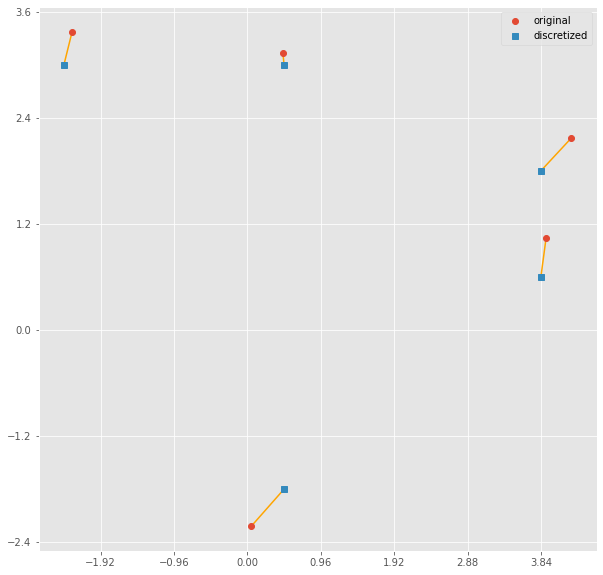

In [15]:
visualize_samples(cart_samples, cart_dsamples, grid[0:2])


### Pole Angle and Angle Velocity

[[ 0.029  0.546]
 [-0.019 -2.455]
 [ 0.398 -1.304]
 [ 0.193  3.198]
 [ 0.099 -1.804]]
[[5 5]
 [4 1]
 [9 3]
 [7 8]
 [6 2]]
[array([-0.335, -0.251, -0.168, -0.084,  0.   ,  0.084,  0.168,  0.251,  0.335]), array([-3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2])]


D:\dev\software\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


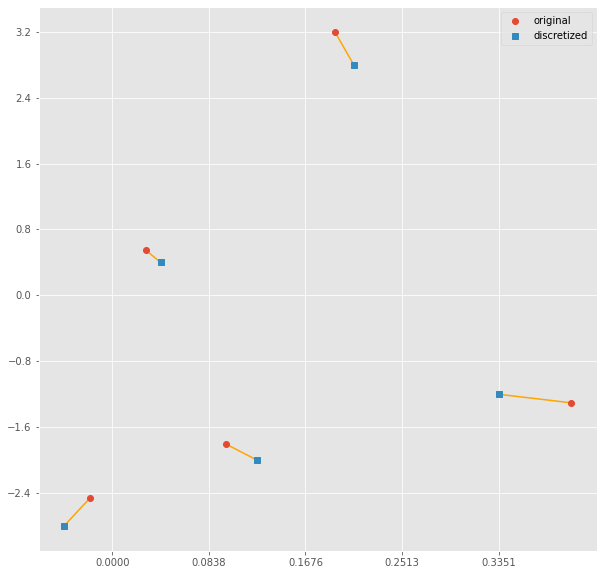

In [16]:
visualize_samples(pole_samples, pole_dsamples, grid[2:])


### Create Uniform State Grid and test discretize

Now that we have a way to discretize a state space, let's apply it to our reinforcement
learning environment.

In [17]:
# Create a grid to discretize the state space
state_grid = Grid.create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10, 10, 10))
state_grid

[array([-3.84, -2.88, -1.92, -0.96,  0.  ,  0.96,  1.92,  2.88,  3.84]),
 array([-4.8, -3.6, -2.4, -1.2,  0. ,  1.2,  2.4,  3.6,  4.8]),
 array([-0.335, -0.251, -0.168, -0.084,  0.   ,  0.084,  0.168,  0.251,  0.335]),
 array([-3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2])]

In [18]:
# Obtain some samples from the space
state_samples = np.array([env.observation_space.sample() for i in range(10)])
print(state_samples)

# Discretize them
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
print(discretized_state_samples)


[[ 0.627 -0.573 -0.289 -2.207]
 [-4.201 -4.916 -0.06   2.485]
 [ 1.915  3.154  0.163 -0.803]
 [-1.781 -5.679 -0.117  1.716]
 [-4.619  0.828 -0.333  0.393]
 [-0.349  4.243 -0.23  -3.891]
 [-0.832  5.401 -0.335  3.774]
 [-0.59   1.835 -0.049  2.734]
 [-1.963  3.232  0.348  1.943]
 [ 1.723 -1.817 -0.223  0.331]]
[[5 4 1 2]
 [0 0 4 8]
 [6 7 6 3]
 [3 0 3 7]
 [0 5 1 5]
 [4 8 2 0]
 [4 9 1 9]
 [4 6 4 8]
 [2 7 9 7]
 [6 3 2 5]]


## 5. Q-Learning

Provided below is a simple Q-Learning agent.
Implement the `preprocess_state()` method to convert each continuous state sample to its corresponding
discretized representation.

### QLearningAgent

In [19]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9999, min_epsilon=.001, seed=505):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        # print("state:", state)
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward

            # print("self.last_state:", self.last_state, type(self.last_state))
            # print("self.last_action:", self.last_action, type(self.last_action))
            # print("self.last_action:", (self.last_action,), type((self.last_action,)))
            # print("index", self.last_state + (self.last_action,))
            # print(self.q_table)
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

    
q_agent = QLearningAgent(env, state_grid)

Environment: <TimeLimit<CartPoleEnv<CartPole-v0>>>
State space size: (10, 10, 10, 10)
Action space size: 2
Q table size: (10, 10, 10, 10, 2)


### Run QLearningAgent

Let's also define a convenience function to run an agent on a given environment.
When calling this function, you can pass in `mode='test'` to tell the agent not to learn.

In [20]:
# def run(agent, env, num_episodes=20000, mode='train'):

def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            # print("agent.act params:", state, reward, done, mode)
            action = agent.act(state, reward, done, mode)

        # Save final score
        # print("total_reward:", total_reward)
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()

    return scores

scores = run(q_agent, env)

Episode 20000/20000 | Max Average Score: 200.04

### Plot scores obtained per episode

The best way to analyze if your agent was learning the task is to plot the scores.
It should generally increase as the agent goes through more episodes.

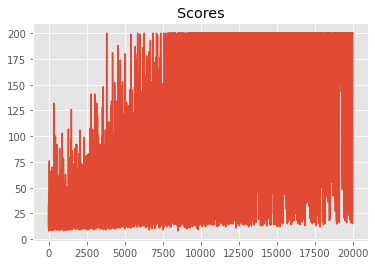

In [21]:
plt.plot(scores); plt.title("Scores");

If the scores are noisy, it might be difficult to tell whether your agent is actually learning. To find the underlying trend, you may want to plot a rolling mean of the scores. Let's write a convenience function to plot both raw scores as well as a rolling mean.

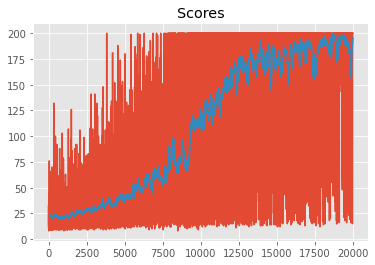

In [22]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

## 6. Modify the Grid

Now it's your turn to play with the grid definition and see what gives you optimal results.
Your agent's final performance is likely to get better if you use a finer grid, with more bins per dimension,
at the cost of higher model complexity (more parameters to learn).

### Create new State Grid

In [23]:
state_grid_new = Grid.create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(8,8,8,8))
q_agent_new = QLearningAgent(env, state_grid_new)
q_agent_new.scores = []  # initialize a list to store scores for this agent


Environment: <TimeLimit<CartPoleEnv<CartPole-v0>>>
State space size: (8, 8, 8, 8)
Action space size: 2
Q table size: (8, 8, 8, 8, 2)


### Train it over a desired number of episodes and analyze scores
Note: This cell can be run multiple times, and scores will get accumulated

Episode 20000/20000 | Max Average Score: 199.53

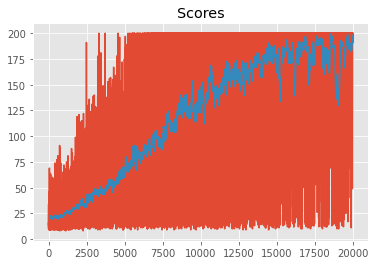

In [24]:
q_agent_new.scores += run(q_agent_new, env, num_episodes=20000)  # accumulate scores
rolling_mean_new = plot_scores(q_agent_new.scores)


### Run in test mode and analyze scores obtained

[TEST] Completed 200 episodes with avg. score = 199.97


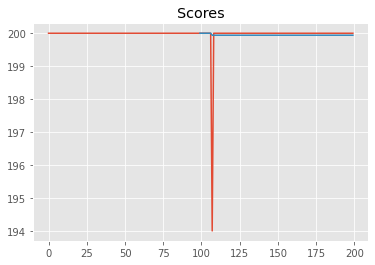

In [25]:
test_scores = run(q_agent_new, env, num_episodes=200, mode='test')
print("[TEST] Completed {} episodes with avg. score = {}".format(len(test_scores), np.mean(test_scores)))
_ = plot_scores(test_scores)

## 7. Watch a Smart Agent

Score:  200.0


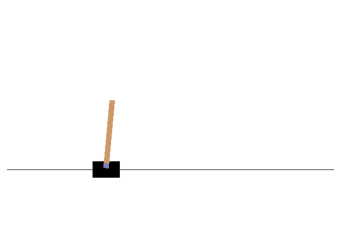

In [26]:
state = env.reset()
score = 0
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = q_agent_new.act(state, mode='test')
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        print('Score: ', score)
        break
        
env.close()


## 8. Modify the Grid to geomspace grid


### Create new State Grid

In [27]:
env = gym.make('CartPole-v0')
env.seed(505);
env.reset()

low  = env.observation_space.low
high = env.observation_space.high

low[1] = -8.0
high[1] = 8.0
low[3] = -6.0
high[3] = 6.0


bins = (8,12,8,12)
funcs= ("uni","geom","uni","geom")

print(low)
print(high)

state_grid_geom = Grid.create_mixed_grid(low, high, bins, funcs)

for g in state_grid_geom:
    print(g)


# (self, env, state_grid, alpha=0.02, gamma=0.99,
#  epsilon=1.0, epsilon_decay_rate=0.9999, min_epsilon=.001, seed=505)

q_agent_geom = QLearningAgent(env, state_grid_geom,
                              alpha=0.015, # learning rate
                              gamma=0.95, # discount factor
                              epsilon=1.0, epsilon_decay_rate=0.9999, min_epsilon=.001,
                              seed=505)

q_agent_geom.scores = []  # initialize a list to store scores for this agent


[-4.8   -8.    -0.419 -6.   ]
[4.8   8.    0.419 6.   ]
[-3.6 -2.4 -1.2  0.   1.2  2.4  3.6]
[-3.330212829607492, -1.3862896863102925, -0.5770799623628854, -0.24022488679628626, -0.1, 0, 0.1, 0.24022488679628626, 0.5770799623628854, 1.3862896863102925, 3.330212829607492]
[-0.314 -0.209 -0.105  0.     0.105  0.209  0.314]
[-2.645580618665161, -1.1665161349761228, -0.5143520796755041, -0.22679331552660548, -0.1, 0, 0.1, 0.22679331552660548, 0.5143520796755041, 1.1665161349761228, 2.645580618665161]
Environment: <TimeLimit<CartPoleEnv<CartPole-v0>>>
State space size: (8, 12, 8, 12)
Action space size: 2
Q table size: (8, 12, 8, 12, 2)


### Train it over a desired number of episodes and analyze scores
Note: This cell can be run multiple times, and scores will get accumulated

Episode 30000/30000 | Max Average Score: 198.71

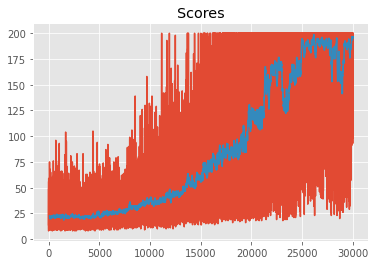

In [28]:
q_agent_geom.scores += run(q_agent_geom, env, num_episodes=30000)  # accumulate scores
rolling_mean_geom = plot_scores(q_agent_geom.scores)

### Run in test mode and analyze scores obtained

[TEST] Completed 3000 episodes with avg. score = 192.726


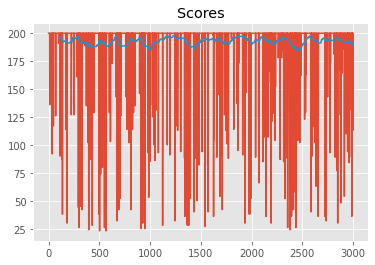

In [29]:
test_scores = run(q_agent_geom, env, num_episodes=3000, mode='test')
print("[TEST] Completed {} episodes with avg. score = {}".format(len(test_scores), np.mean(test_scores)))
_ = plot_scores(test_scores)


__The end.__